# Clustering Time Series using a Pretrained Encoder (Autoencoder + K-Means)
### CMPE 255 — Data Mining  

In this notebook, I will:

- Generate synthetic time series data (different patterns)
- Train a **time series autoencoder** (pretrained encoder)
- Use the encoder to obtain **fixed-size embeddings** for each time series
- Cluster the embeddings using **K-Means**
- Visualize the time series grouped by clusters

This illustrates the common pipeline in **pretrained time series models**:
> Time Series → Pretrained Encoder → Embeddings → Clustering


In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

plt.rcParams["figure.figsize"] = (7, 4)
device = "cuda" if torch.cuda.is_available() else "cpu"
device


'cpu'

In [2]:
np.random.seed(42)

n_series_per_cluster = 30
seq_len = 100
t = np.linspace(0, 2 * np.pi, seq_len)

series_list = []
labels_true = []

# Cluster 0: Sine waves with noise
for _ in range(n_series_per_cluster):
    s = np.sin(t) + 0.2 * np.random.randn(seq_len)
    series_list.append(s)
    labels_true.append(0)

# Cluster 1: "Square-wave" like pattern
for _ in range(n_series_per_cluster):
    s = np.sign(np.sin(t)) + 0.2 * np.random.randn(seq_len)
    series_list.append(s)
    labels_true.append(1)

# Cluster 2: Upward trending lines with noise
for _ in range(n_series_per_cluster):
    s = np.linspace(0, 1, seq_len) + 0.2 * np.random.randn(seq_len)
    series_list.append(s)
    labels_true.append(2)

series_array = np.stack(series_list)         # (n_series, seq_len)
labels_true = np.array(labels_true)         # ground-truth cluster ids
print("Series array shape:", series_array.shape)
print("True labels shape:", labels_true.shape)


Series array shape: (90, 100)
True labels shape: (90,)


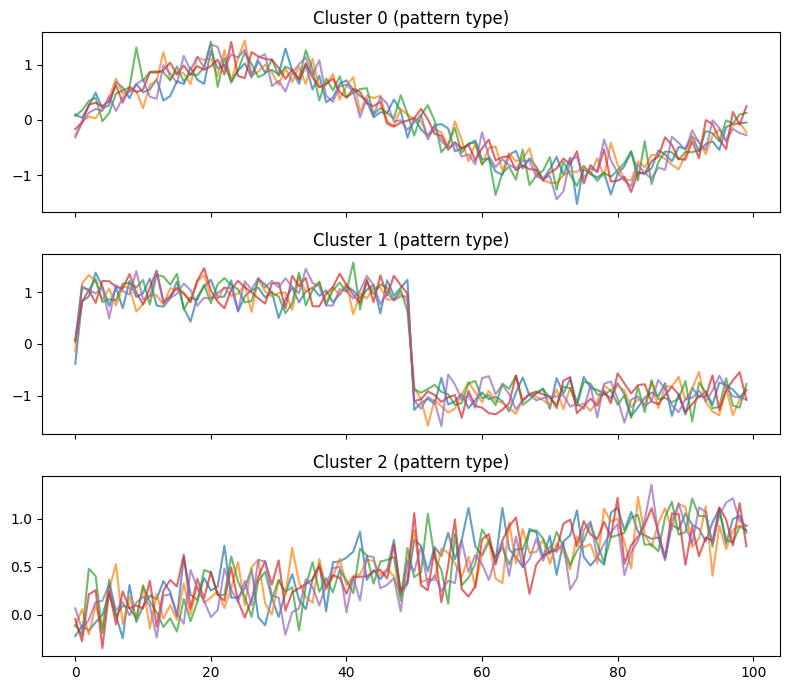

In [3]:
n_plot = 5
fig, axes = plt.subplots(3, 1, figsize=(8, 7), sharex=True)

for i, c in enumerate([0, 1, 2]):
    idx = np.where(labels_true == c)[0][:n_plot]
    for j in idx:
        axes[i].plot(series_array[j], alpha=0.7)
    axes[i].set_title(f"Cluster {c} (pattern type)")
plt.tight_layout()
plt.show()


In [4]:
# Normalize each series (zero mean, unit variance)
scaler = StandardScaler()
series_norm = scaler.fit_transform(series_array)  # shape (n_series, seq_len)

# Reshape for PyTorch: (n_series, seq_len, 1)
series_norm = series_norm[..., np.newaxis]
series_norm.shape


(90, 100, 1)

In [5]:
class TimeSeriesDataset(Dataset):
    def __init__(self, data):
        # data: (n_series, seq_len, 1)
        self.data = torch.tensor(data, dtype=torch.float32)

    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, idx):
        # We use same input and output for autoencoder
        x = self.data[idx]      # (seq_len, 1)
        return x, x

dataset = TimeSeriesDataset(series_norm)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)
len(dataset)


90

In [7]:
class TimeSeriesAutoencoder(nn.Module):
    def __init__(self, seq_len=100, emb_dim=16):
        super().__init__()
        self.seq_len = seq_len
        self.emb_dim = emb_dim

        # Encoder: 1D conv + pooling to compress
        self.encoder_conv = nn.Sequential(
            nn.Conv1d(in_channels=1, out_channels=8, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2),  # seq_len / 2
            nn.Conv1d(in_channels=8, out_channels=16, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2)   # seq_len / 4
        )

        reduced_len = seq_len // 4  # after two poolings
        self.encoder_fc = nn.Linear(16 * reduced_len, emb_dim)

        # Decoder: map emb back to compressed conv shape, then upsample
        self.decoder_fc = nn.Linear(emb_dim, 16 * reduced_len)
        self.decoder_conv = nn.Sequential(
            nn.ConvTranspose1d(in_channels=16, out_channels=8, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose1d(in_channels=8, out_channels=1, kernel_size=4, stride=2, padding=1),
        )

    def encode(self, x):
        # x: (batch, seq_len, 1)
        x = x.permute(0, 2, 1)               # (batch, 1, seq_len)
        z = self.encoder_conv(x)             # (batch, 16, seq_len/4)
        z_flat = z.flatten(start_dim=1)      # (batch, 16 * seq_len/4)
        emb = self.encoder_fc(z_flat)        # (batch, emb_dim)
        return emb

    def decode(self, emb):
        # emb: (batch, emb_dim)
        reduced_len = self.seq_len // 4
        z = self.decoder_fc(emb)             # (batch, 16 * reduced_len)
        z = z.view(-1, 16, reduced_len)      # (batch, 16, reduced_len)
        out = self.decoder_conv(z)           # (batch, 1, seq_len)
        out = out.permute(0, 2, 1)           # (batch, seq_len, 1)
        return out

    def forward(self, x):
        emb = self.encode(x)
        recon = self.decode(emb)
        return recon


In [8]:
seq_len = series_norm.shape[1]
emb_dim = 16

model = TimeSeriesAutoencoder(seq_len=seq_len, emb_dim=emb_dim).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

n_epochs = 20

model.train()
for epoch in range(1, n_epochs + 1):
    epoch_loss = 0.0
    for batch_x, _ in dataloader:
        batch_x = batch_x.to(device)

        optimizer.zero_grad()
        recon = model(batch_x)
        loss = criterion(recon, batch_x)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item() * batch_x.size(0)

    epoch_loss /= len(dataset)
    if epoch % 5 == 0 or epoch == 1:
        print(f"Epoch {epoch}/{n_epochs}, Reconstruction Loss: {epoch_loss:.4f}")


Epoch 1/20, Reconstruction Loss: 1.1359
Epoch 5/20, Reconstruction Loss: 0.5663
Epoch 10/20, Reconstruction Loss: 0.2572
Epoch 15/20, Reconstruction Loss: 0.1964
Epoch 20/20, Reconstruction Loss: 0.1802


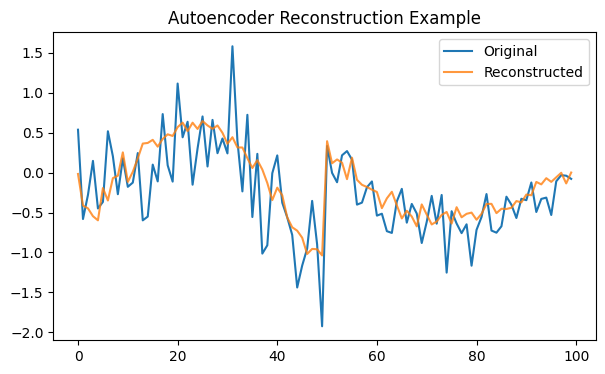

In [9]:
model.eval()

with torch.no_grad():
    sample_x, _ = dataset[0]              # first series
    sample_x = sample_x.unsqueeze(0).to(device)  # (1, seq_len, 1)
    recon_x = model(sample_x).cpu().squeeze().numpy()

orig = dataset[0][0].numpy().squeeze()

plt.plot(orig, label="Original")
plt.plot(recon_x, label="Reconstructed", alpha=0.8)
plt.title("Autoencoder Reconstruction Example")
plt.legend()
plt.show()


In [10]:
model.eval()
embeddings = []

with torch.no_grad():
    for i in range(len(dataset)):
        x, _ = dataset[i]                 # (seq_len, 1)
        x = x.unsqueeze(0).to(device)     # (1, seq_len, 1)
        emb = model.encode(x)             # (1, emb_dim)
        embeddings.append(emb.cpu().numpy().squeeze())

embeddings = np.stack(embeddings)         # (n_series, emb_dim)
print("Embeddings shape:", embeddings.shape)


Embeddings shape: (90, 16)


In [11]:
k = 3  # since we know we created 3 pattern types
kmeans = KMeans(n_clusters=k, random_state=42, n_init="auto")
labels_cluster = kmeans.fit_predict(embeddings)

print("Cluster labels:", np.unique(labels_cluster))


Cluster labels: [0 1 2]


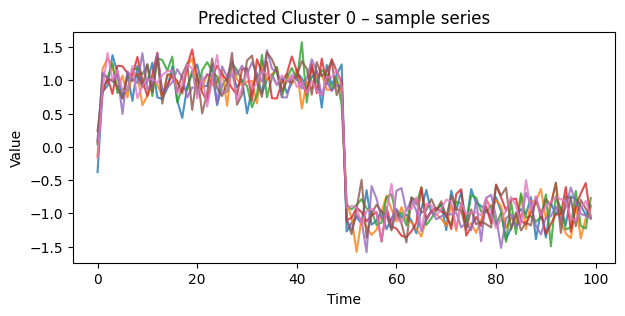

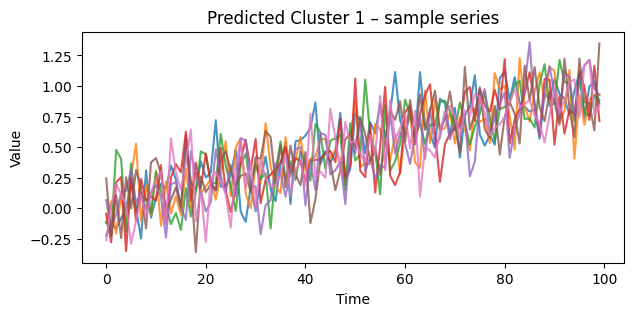

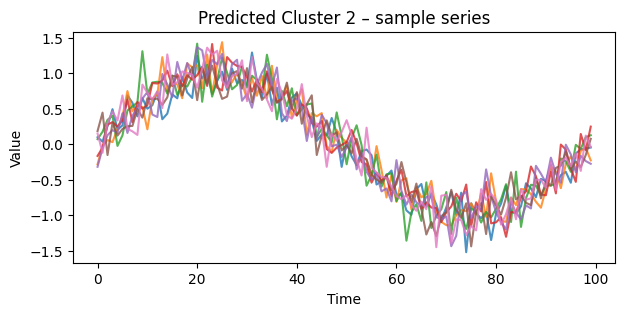

In [12]:
def plot_cluster_series(cluster_id, labels_cluster, series_array, n_plot=5):
    idx = np.where(labels_cluster == cluster_id)[0][:n_plot]
    plt.figure(figsize=(7, 3))
    for i in idx:
        plt.plot(series_array[i], alpha=0.8)
    plt.title(f"Predicted Cluster {cluster_id} – sample series")
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.show()

for c in range(k):
    plot_cluster_series(c, labels_cluster, series_array, n_plot=7)


In [13]:
from sklearn.metrics import adjusted_rand_score

ari = adjusted_rand_score(labels_true, labels_cluster)
print("Adjusted Rand Index (true vs predicted clusters):", ari)


Adjusted Rand Index (true vs predicted clusters): 1.0


## Conclusions

- I generated synthetic **time series data** with three different underlying patterns:
  - Sine waves
  - Square-like waves
  - Upward linear trends
- I trained a **time series autoencoder** (1D convolutional encoder–decoder) to reconstruct the series.
- After training, I used the **encoder as a pretrained feature extractor**:
  - Each time series was mapped to a **fixed-size embedding vector**.
- I applied **K-Means clustering** on these embeddings and grouped the time series into clusters.
- Visual inspection of the clusters shows that:
  - Series with similar shapes/patterns are grouped together.
- I also computed the **Adjusted Rand Index (ARI)** between true pattern labels and cluster labels to quantitatively evaluate clustering quality.

This notebook illustrates **time series clustering using a pretrained model (autoencoder encoder + K-Means)** for the CMPE 255 assignment (Part f).
